# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
from ipywidgets import IntProgress
from torch.optim.lr_scheduler import MultiStepLR

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

In [3]:
device

device(type='cuda')

-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. numbper of epoches
5. out put directory

In [4]:
trainBatchSize = 8
testBatchSize = 8
learningRate = 0.001
num_epochs = 26

-----
##  Data Loading
Next, we are going to load our data. 
### We need to prepare our data:

### We first import necessary librarys for data loading

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.utils.data as data

-----
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testting set. Note that the testing spilit do not require any transform

In [6]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [7]:
train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


-----
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paper below to understand the structure.
### https://arxiv.org/abs/1409.4842



------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of two 2D convolutions, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [8]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True)
        )


        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True)
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return torch.cat(
            [self.b1(x), self.b2(x), self.b3(x), self.b4(x)], 1
        )

-----
### GoogLeNet Module (There exist many implement methods)


1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convolution with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    2. Two Inception blocks
    
    3. Maxpooling layer
    
    4. Five Inception blocks
    
    5. Maxpooling layer
    
    6. Two Inception blocks  
    
    7. Average Pooling layer
    
    8. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [9]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        # 2D convolution with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
        self.conv1 = nn.Sequential(
        nn.Conv2d(3, 192, kernel_size=3, padding=1),
        nn.BatchNorm2d(192),
        nn.ReLU(True)
        )
        
        # Two Inception blocks
        self.inception1 = Inception(192,  64,  96, 128, 16,  32,  32)
        self.inception2 = Inception(256, 128, 128, 192, 32,  96,  64)
        
        # Maxpooling layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Five Inception blocks
        self.inception3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inception4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inception5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inception6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.inception7 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        # Maxpooling layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Two Inception blocks
        self.inception8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception9 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        # Average Pooling layer
        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.4)
        
        # A fully connected layer.
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.maxpool1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.inception7(x)
        x = self.maxpool2(x)
        x = self.inception8(x)
        x = self.inception9(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Next, we create the network and send it to the target device

In [10]:
net = GoogLeNet()
net.to(device)

GoogLeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inception1): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [11]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=learningRate)
criterion = nn.CrossEntropyLoss()
scheduler = MultiStepLR(optimizer, 
                        milestones=[10, 20], # List of epoch indices
                        gamma =0.4) # Multiplicative factor of learning rate decay

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [12]:
train_loss = []
train_acc = []

test_loss = []
test_acc = []

for epoch in range(num_epochs):
    accumulated_loss = .0 # accumulated training loss
    correct = 0 # number of correct predictions
    total = 0 # total data
    for data in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # get the inputs and put them to the correct device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # reset the optimizer gradients
        optimizer.zero_grad()

        # forward it to google net
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # backprop the loss
        loss.backward()
        
        # update the params
        optimizer.step()
        
        accumulated_loss += loss.item() # accumulate the training lsos
        _, predicted = torch.max(outputs.data, 1) # find the prediction
        total += labels.size(0) # increment the data size
        correct += (predicted == labels).sum().item()
        
    train_loss.append(accumulated_loss)
    current_train_acc = correct / total # calculate accuracy
    train_acc.append(current_train_acc)
    
    # printing the log
    print('\nEpoch: {}'.format(epoch+1))
    print('Train Acc. => {:.3f}%'.format(100 * current_train_acc), end=' | ')
    print('Train Loss => {:.5f}'.format(accumulated_loss))
    
    with torch.no_grad():
        test_accumulated_loss = .0 # accumulated test loss
        correct = 0 # correct predictions
        total = 0 # total data
        for data in test_loader:
            # get the inputs and send them to correct device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # feed forwards
            outputs = net(inputs)
            
            # compute the loss term
            loss = criterion(outputs, labels)
            
            test_accumulated_loss += loss.item() # accumulate test loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_loss.append(test_accumulated_loss)
        current_test_acc = correct / total
        test_acc.append(current_test_acc)
        
        print('Test Acc.  => {:.3f}%'.format(100 * current_test_acc), end=' | ')
        print('Test Loss  => {:.5f}'.format(test_accumulated_loss))
    
    scheduler.step() # stepping the sceduler at the end as suggested due to the update
        
print('Finished Training')

Epoch 1/26: 100%|██████████| 6250/6250 [03:27<00:00, 30.06it/s]



Epoch: 1
Train Acc. => 43.356% | Train Loss => 9724.91633
Test Acc.  => 57.920% | Test Loss  => 1490.45351


Epoch 2/26: 100%|██████████| 6250/6250 [03:27<00:00, 30.09it/s]



Epoch: 2
Train Acc. => 65.320% | Train Loss => 6282.78597
Test Acc.  => 70.450% | Test Loss  => 1093.47874


Epoch 3/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.32it/s]



Epoch: 3
Train Acc. => 73.408% | Train Loss => 4870.20385
Test Acc.  => 73.770% | Test Loss  => 974.61906


Epoch 4/26: 100%|██████████| 6250/6250 [03:27<00:00, 30.14it/s]



Epoch: 4
Train Acc. => 77.752% | Train Loss => 4083.08672
Test Acc.  => 78.910% | Test Loss  => 789.02230


Epoch 5/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.25it/s]



Epoch: 5
Train Acc. => 80.642% | Train Loss => 3548.57625
Test Acc.  => 80.910% | Test Loss  => 704.57627


Epoch 6/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.30it/s]



Epoch: 6
Train Acc. => 83.104% | Train Loss => 3090.79303
Test Acc.  => 81.200% | Test Loss  => 690.91507


Epoch 7/26: 100%|██████████| 6250/6250 [03:24<00:00, 30.49it/s]



Epoch: 7
Train Acc. => 84.816% | Train Loss => 2763.58940
Test Acc.  => 83.250% | Test Loss  => 620.51523


Epoch 8/26: 100%|██████████| 6250/6250 [03:27<00:00, 30.17it/s]



Epoch: 8
Train Acc. => 86.562% | Train Loss => 2469.13344
Test Acc.  => 83.740% | Test Loss  => 608.58902


Epoch 9/26: 100%|██████████| 6250/6250 [03:23<00:00, 30.76it/s]



Epoch: 9
Train Acc. => 87.764% | Train Loss => 2216.41628
Test Acc.  => 84.840% | Test Loss  => 559.18066


Epoch 10/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.27it/s]



Epoch: 10
Train Acc. => 88.890% | Train Loss => 2028.55393
Test Acc.  => 85.500% | Test Loss  => 559.41747


Epoch 11/26: 100%|██████████| 6250/6250 [03:27<00:00, 30.18it/s]



Epoch: 11
Train Acc. => 92.374% | Train Loss => 1385.85027
Test Acc.  => 87.700% | Test Loss  => 480.33136


Epoch 12/26: 100%|██████████| 6250/6250 [03:25<00:00, 30.45it/s]



Epoch: 12
Train Acc. => 93.666% | Train Loss => 1145.83752
Test Acc.  => 87.610% | Test Loss  => 471.42403


Epoch 13/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.31it/s]



Epoch: 13
Train Acc. => 94.356% | Train Loss => 1035.00345
Test Acc.  => 87.930% | Test Loss  => 468.70844


Epoch 14/26: 100%|██████████| 6250/6250 [03:29<00:00, 29.79it/s]



Epoch: 14
Train Acc. => 95.006% | Train Loss => 921.06822
Test Acc.  => 87.740% | Test Loss  => 503.93878


Epoch 15/26: 100%|██████████| 6250/6250 [03:28<00:00, 29.96it/s]



Epoch: 15
Train Acc. => 95.530% | Train Loss => 816.33449
Test Acc.  => 88.430% | Test Loss  => 485.35880


Epoch 16/26: 100%|██████████| 6250/6250 [03:21<00:00, 31.02it/s]



Epoch: 16
Train Acc. => 95.900% | Train Loss => 734.84815
Test Acc.  => 88.070% | Test Loss  => 498.41961


Epoch 17/26: 100%|██████████| 6250/6250 [03:21<00:00, 30.95it/s]



Epoch: 17
Train Acc. => 96.390% | Train Loss => 653.27584
Test Acc.  => 88.180% | Test Loss  => 528.93467


Epoch 18/26: 100%|██████████| 6250/6250 [03:27<00:00, 30.11it/s]



Epoch: 18
Train Acc. => 96.700% | Train Loss => 594.38892
Test Acc.  => 88.490% | Test Loss  => 525.10855


Epoch 19/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.25it/s]



Epoch: 19
Train Acc. => 96.938% | Train Loss => 559.52342
Test Acc.  => 88.530% | Test Loss  => 555.86724


Epoch 20/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.31it/s]



Epoch: 20
Train Acc. => 97.126% | Train Loss => 505.39508
Test Acc.  => 88.220% | Test Loss  => 552.67397


Epoch 21/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.25it/s]



Epoch: 21
Train Acc. => 98.162% | Train Loss => 328.78983
Test Acc.  => 89.310% | Test Loss  => 530.98977


Epoch 22/26: 100%|██████████| 6250/6250 [03:25<00:00, 30.46it/s]



Epoch: 22
Train Acc. => 98.632% | Train Loss => 252.70968
Test Acc.  => 88.960% | Test Loss  => 551.99168


Epoch 23/26: 100%|██████████| 6250/6250 [03:23<00:00, 30.79it/s]



Epoch: 23
Train Acc. => 98.778% | Train Loss => 228.02870
Test Acc.  => 89.250% | Test Loss  => 559.00306


Epoch 24/26: 100%|██████████| 6250/6250 [03:24<00:00, 30.56it/s]



Epoch: 24
Train Acc. => 98.932% | Train Loss => 200.42805
Test Acc.  => 89.360% | Test Loss  => 581.13318


Epoch 25/26: 100%|██████████| 6250/6250 [03:25<00:00, 30.38it/s]



Epoch: 25
Train Acc. => 99.068% | Train Loss => 171.64909
Test Acc.  => 89.410% | Test Loss  => 564.47889


Epoch 26/26: 100%|██████████| 6250/6250 [03:26<00:00, 30.26it/s]



Epoch: 26
Train Acc. => 99.072% | Train Loss => 178.74762
Test Acc.  => 89.360% | Test Loss  => 588.41440
Finished Training


In [13]:
import matplotlib.pyplot as plt

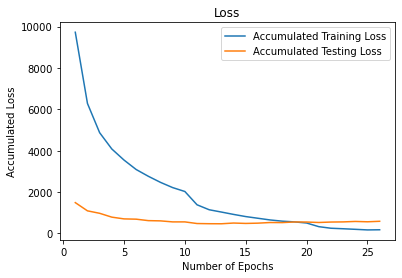

In [14]:
x = [i+1 for i in range(num_epochs)]
plt.plot(x, train_loss, label='Accumulated Training Loss')
plt.plot(x, test_loss, label='Accumulated Testing Loss')

# add axis labels and a title
plt.xlabel('Number of Epochs')
plt.ylabel('Accumulated Loss')
plt.title('Loss')

# add a legend to distinguish the two lines
plt.legend()

# display the graph
plt.show()